In [1]:
!pip3 install hyperopt

    100% |████████████████████████████████| 972kB 9.5MB/s ta 0:00:011
    100% |████████████████████████████████| 829kB 11.0MB/s ta 0:00:01
    100% |████████████████████████████████| 1.6MB 12.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
  Found existing installation: networkx 2.1
    Uninstalling networkx-2.1:
      Successfully uninstalled networkx-2.1
You are using pip version 10.0.1, however version 20.1b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip3 install imblearn

    100% |████████████████████████████████| 163kB 6.9MB/s ta 0:00:01
    100% |████████████████████████████████| 296kB 9.1MB/s eta 0:00:01
    100% |████████████████████████████████| 7.1MB 6.7MB/s eta 0:00:01
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
You are using pip version 10.0.1, however version 20.1b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip3 install seaborn==0.10

    100% |████████████████████████████████| 225kB 871kB/s ta 0:00:011
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
  Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:
      Successfully uninstalled seaborn-0.8.1
You are using pip version 10.0.1, however version 20.1b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import math
import warnings
from datetime import datetime
from collections import OrderedDict
from io import BytesIO

import test as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTEENN

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier, ElasticNet, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils

from hyperopt import hp, tpe, fmin

import boto3

warnings.filterwarnings("ignore")
%matplotlib inline

In [5]:
#Set numpy seed
SEED = 314
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
BUCKET = "mlend-capstone"
FILENAME = "engineered_data.csv" #Preprocessed data from the previous notebook

In [7]:
obj = boto3.client('s3').get_object(Bucket=BUCKET, Key='engineered_data.csv')
data = pd.read_csv(BytesIO(obj['Body'].read()), index_col=False)

data.tail()

,Age,prev_visits,prev_noshows,pct_noshows,days_wait,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,appt_day,NoShow
110522,0.818306,-0.234780,0.320478,0.949247,-1.626773,0,0,0,0,0,1,1,0
110523,0.601950,0.070005,0.320478,0.153079,-1.626773,0,0,0,0,0,1,1,0
110524,-0.696184,-0.387172,-0.552273,-0.643089,-2.020088,0,0,0,0,0,1,1,0
110525,0.039425,-0.234780,-0.552273,-0.643089,-2.020088,0,0,0,0,0,1,1,0
110526,0.731763,-0.234780,-0.552273,-0.643089,-2.020088,0,0,0,0,0,1,1,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 13 columns):
Age             110527 non-null float64
prev_visits     110527 non-null float64
prev_noshows    110527 non-null float64
pct_noshows     110527 non-null float64
days_wait       110527 non-null float64
Scholarship     110527 non-null int64
Hypertension    110527 non-null int64
Diabetes        110527 non-null int64
Alcoholism      110527 non-null int64
Handicap        110527 non-null int64
SMS_received    110527 non-null int64
appt_day        110527 non-null int64
NoShow          110527 non-null int64
dtypes: float64(5), int64(8)
memory usage: 11.0 MB


In [9]:
#Change some of the in64 columns to category columns
cat_cols = ['Scholarship', 'Hypertension', 'Diabetes', 
            'Alcoholism', 'Handicap', 'SMS_received', 'appt_day']

data[cat_cols] = data[cat_cols].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 13 columns):
Age             110527 non-null float64
prev_visits     110527 non-null float64
prev_noshows    110527 non-null float64
pct_noshows     110527 non-null float64
days_wait       110527 non-null float64
Scholarship     110527 non-null category
Hypertension    110527 non-null category
Diabetes        110527 non-null category
Alcoholism      110527 non-null category
Handicap        110527 non-null category
SMS_received    110527 non-null category
appt_day        110527 non-null category
NoShow          110527 non-null int64
dtypes: category(7), float64(5), int64(1)
memory usage: 5.8 MB


# Functions and Classes

Here we define several functions and classes that will be needed to conduct the experiments

In [10]:
def get_col_info(df):
    """
    Get lists of column names for continuous and categorical columns as well
    as the embedding sizes for categorical columns
        ARGS:
            df(DataFrame): dataframe of samples (no label column)
        RETURN:
            two lists of column names and one list of 
                tuples (# categoris, embedding dimension)
    """
    embedding_columns = {n: len(col.cat.categories) for n,col in df.items() \
                         if (isinstance(col.dtype,pd.core.dtypes.dtypes.CategoricalDtype))}

    embedding_col_names = list(embedding_columns.keys())

    embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) \
                       for _,n_categories in embedding_columns.items()]

    cont_col_names = [col for col in df.columns if col not in embedding_col_names]
    
    return embedding_col_names, embedding_sizes, cont_col_names


def conic_layer_widths(num_layers, starting_width, output_size):
    """
    Determines a geometric progression for layer widths if the model
    architecture is conic
        ARGS:
            num_layers(int):= number of hidden layers (depth of network)
            starting_width(int):= number of neurons in the first hidden
                layer
            output_size(int):= dimension of the output tensor
        RETURN:
            list of integer layer depths
    """
    widths = np.zeros(shape=num_layers, dtype=np.int)
    ratio = (starting_width / output_size) ** (1/float(num_layers))
    
    for i in range(num_layers):
        widths[i] = int(starting_width * (ratio ** -i))
        
    return list(widths)


def init_weights(param):
    """
    Initializes the weights of the network using weights drawn on a
    normal distribution with mean 0 and stdev 1/sqrt(#output features)
        ARGS:
            param:= weight tensor for Linear layers
        RETURN:
            None
    """
    if type(param) == nn.Linear:
        torch.nn.init.normal_(param.weight, 0.0, 1/math.sqrt(param.out_features))
        param.bias.data.fill_(0.0)


class TabDataset(utils.data.Dataset):
    """Dataset for tabular data with continuous and categorical variables"""
    def __init__(self, X, y, embedding_cols):
        """
        Initializes the TabDataset object
            ARGS:
                X(DataFrame): dataframe of samples
                y(array-like): array-like object of labels
                embedding_cols: list of column names with categorical variables
        """
        X = X.copy()
        self.X_embed = X.loc[:,embedding_cols].astype(np.int64)
        self.X_cont = X.drop(columns=embedding_cols).astype(np.float32)
        self.y = pd.DataFrame(y, index=X.index).astype(np.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_embed.iloc[idx].values, self.X_cont.iloc[idx].values, self.y.iloc[idx].values
    

class NoShowModel(nn.Module):
    """Self-Normalizing Network"""
    """https://arxiv.org/abs/1706.02515"""
    def __init__(self, embed_sizes, num_cont, 
                 first_layer_size, output_layer_size,
                 network_shape, num_layers,
                 drops={'emb':0.05,'cont':0.03}):
        """
        Initializes a SNN with specified architecture.
            ARGS:
                embed_sizes(list of tuples):= list of (# categories, embed dim) for
                    categorical variables
                num_cont(int):= number of continuous variables
                first_layer_size(int):= width of the first hidden layer
                output_layer_size(int):= dimension of the output tensor
                network_shape(['rect', conic]):= specifies the shape of the 
                    fully-connectedhidden layers
                num_layers(int):= number of fully-connected hidden layers
                drops(dict):= specifies the dropout probability for the embedding layers
                    and the continuous layers (continuous applies to fully-connected
                    layers in the main hidden block)
        """
        super().__init__()
        assert network_shape in ['rect', 'conic']
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embed_sizes])
        self.num_embed_feats = sum(emb.embedding_dim for emb in self.embeddings)
        self.num_cont = num_cont
        
        self.bn_cont = nn.BatchNorm1d(self.num_cont)
        self.bn_emb = nn.BatchNorm1d(self.num_embed_feats)
        
        self.emb_drop = nn.Dropout(drops['emb'])
        self.fc_drop = nn.Dropout(drops['cont'])
        
        #Construct fully-connected body
        self.fc_dict = OrderedDict()
        
        if network_shape == 'rect':
            self.layer_widths = [first_layer_size for i in range(num_layers)]
        elif network_shape == 'conic':
            self.layer_widths = conic_layer_widths(num_layers, first_layer_size, output_layer_size)
            
        #Adds layer to connect head to fc body
        fc = {f'linear{0}':nn.Linear(self.num_embed_feats+self.num_cont, first_layer_size)}
        bn = {f'b_norm{0}':nn.BatchNorm1d(first_layer_size)}
        do = {f'dropout{0}':nn.Dropout(drops['cont'])}
        al = {f'selu{0}':nn.SELU()}
        block = [fc,bn,do,al]
        for layer in block:
            self.fc_dict.update(layer)
        
        #Create rest of fc body
        for i, width in enumerate(self.layer_widths):
            if i != (num_layers-1):
                fc = {f'linear{i+1}':nn.Linear(width, self.layer_widths[i+1])}
                bn = {f'b_norm{i+1}':nn.BatchNorm1d(self.layer_widths[i+1])}
                do = {f'dropout{i+1}':nn.Dropout(drops['cont'])}
                al = {f'selu{i+1}':nn.SELU()}
                block = [fc,bn,do,al]
                for layer in block:
                    self.fc_dict.update(layer)
            elif i == (num_layers-1): #Special case for last layer where activation is not applied
                fc = {f'linear{i+1}':nn.Linear(width, output_layer_size)}
                bn = {f'b_norm{i+1}':nn.BatchNorm1d(output_layer_size)}
                do = {f'dropout{i+1}':nn.Dropout(drops['cont'])}
                block = [fc,bn,do]
                for layer in block:
                    self.fc_dict.update(layer)
            
        
        self.fc_body = nn.Sequential(self.fc_dict)
        
    def forward(self, x_cat, x_cont):
        x_emb = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x_emb = torch.cat(x_emb, 1)
        x_emb = self.emb_drop(self.bn_emb(x_emb))
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x_emb, x_cont], 1)
        out = self.fc_body(x)
        
        return out
    

In [11]:
#For sklearn models
def balance_data(X, y, seed):
    """
    Performs SMOTE follwed by Edited Nearest Neighbors to balance the dataset.
        ARGS:
            X(DataFrame):= dataframe of samples
            y(Series):= series of corresponding labels
            seed(int):= random seed for reproducability
        RETURN:
            resampled dataset and samples
    """
    smote_enn = SMOTEENN(random_state=seed)
    X_resamp, y_resamp = smote_enn.fit_resample(X, y)
    return X_resamp, y_resamp


def data_pipeline(X, y, test_prop, seed, snn=False):
    """
    Pipeline to balance the data and split into train and test sets in 
    preparation for model training.
        ARGS:
            X(DataFrame):= dataframe of samples
            y(Series):= series of corresponding labels
            test_prop(0<float<1):= proportion of the total dataset that
                will become the test set
            seed(int):= random seed for reproducability
            snn(bool):= the data is being prepared for a snn model
        RETURN:
            if not snn:
                resampled and split train and test, sample and label sets
                packaged in a dictionary
            if snn:
                resampled and split train and test dataloaders packaged in a
                dictionary
    """
    X_resamp, y_resamp = balance_data(X, y, seed)
    X_train, X_test, y_train, y_test = train_test_split(X_resamp, y_resamp, 
                                                        test_size=test_prop,
                                                        random_state=seed
                                                       )
    datasets = {'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
               }
    
    return datasets


def prepare_model(model_type, model_args):
    """
    Instantiates a model of the specified model type with the specified 
    arguments
        ARGS:
            model_type:= sklearn model
            model_args:= dict of model arguments
        RETURN:
            instance of the model type
    """
    model = model_type(**model_args)
    return model


def train_eval(model, data, metric):
    """
    Trains and evaluates a sklearn model and scores its performance
        ARGS:
            model:= sklearn model instance
            data(dict):= dictionary containing X_train, X_test, y_train, 
                and y_test
            metric:= sklearn score function
        RETURN:
            score of the trained model
    """
    model.fit(data['X_train'], data['y_train'])
    preds = model.predict(data['X_test'])
    score = metric(data['y_test'], preds)
    
    return score


def single_experiment(X, y, model_type, metric,
                      test_prop, seed, model_args):
    """
    Conducts a single experiment from data resampling, data splitting, 
    model training, and model evaluation
        ARGS:
            X(DataFrame):= dataframe of samples
            y(Series):= series of corresponding labels
            model_type:= sklearn model
            metric:= sklearn score function
            test_prop(0<float<1):= proportion of the total dataset that
                will become the test set
            seed(int):= random seed for reproducability
            model_args:= dict of model arguments
        RETURN:
            score of the trained model
    """
    data = data_pipeline(X, y, test_prop, seed)
    model = prepare_model(model_type, model_args)
    score = train_eval(model, data, metric)
    
    return score


def show_experiment_results(scores):
    """
    Displays a scatter plot of the scores, a distribution, and a box plot
    of the score distributions as well as summary statistics of the scores
        ARGS:
            scores(array):= array of scores
    """
    #Scatter plot
    fig, ax1 = plt.subplots(figsize=(6, 3), ncols=1)
    ax1.set_title("Experiment Scores")
    ax1.set_xlabel("Experiment")
    ax1.set_ylabel("Score")
    plt.bar(np.arange(len(scores)), scores)
    plt.show()
    
    #Violin and Box Plot
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 3), ncols=2, sharey=False)
    ax1.set_title("Score Distribution")
    ax2.set_title("Score Box Plot")
    sns.distplot(scores, norm_hist=True, ax=ax1)
    sns.boxplot(scores, ax=ax2)
    plt.show()
    
    #Summary statistics
    print("=== Statistics ===")
    print("Mean: ", round(scores.mean(),4))
    print("Median: ", round(np.median(scores),4))
    print("Standard Dev: ", round(scores.std(),4))
    print("Range: ", (round(scores.min(),4), round(scores.max(),4)))
    


def run_experiments(seeds, X, y, model_type, metric, test_prop, model_args={}, verbose=True, viz=True):
    """
    Runs n experiments using the provided data for a single model type.
        ARGS:
            seeds(list/array of ints):= random seeds to use for 
                len(list/array) number of experiments
            X(DataFrame):= dataframe of samples
            y(Series):= series of corresponding labels
            model_type:= sklearn model
            metric:= sklearn score function
            test_prop(0<float<1):= proportion of the total dataset that
                will become the test set
            seed(int):= random seed for reproducability
            model_args:= dict of model arguments
            verbose(bool):= print experiment results
            viz(bool):= plot visuals and summary statistics
        RETURN:
            numpy array containing scores
    """
    scores = []
    
    for i,seed in enumerate(seeds):
        if verbose:
            print(f"Running experiment {i+1}")
        score = single_experiment(X, y, model_type, metric,
                                  test_prop, seed, model_args)
        scores.append(score)
        if verbose:
            print(f"Completed experiment. Score: {score}")
        
    scores = np.array(scores)
    
    if viz:
        show_experiment_results(scores)
    
    return scores
    

[764 277 515 305 108 392 905]
Params:  (123, 987)
Fit called properly
Params:  (123, 987)
Fit called properly
Params:  (123, 987)
Fit called properly
Params:  (123, 987)
Fit called properly
Params:  (123, 987)
Fit called properly
Params:  (123, 987)
Fit called properly
Params:  (123, 987)
Fit called properly


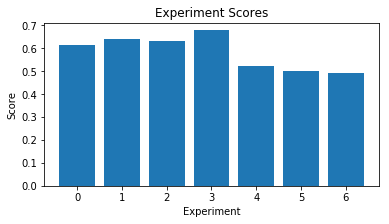

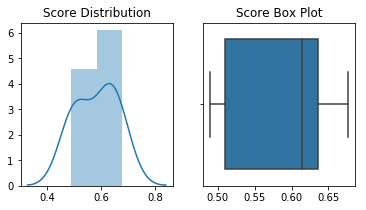

=== Statistics ===
Mean:  0.5817
Median:  0.6136
Standard Dev:  0.0705
Range:  (0.4896, 0.6771)


In [12]:
#Test sklearn experiment set up
seeds = np.random.choice(np.arange(1000), size=(7), replace=False)
print(seeds)
X = pd.DataFrame(np.random.normal(0.0, 1.0, size=(100,4)))
y = pd.Series(np.random.choice([0,1], size=(100), p=[0.3,0.7]))
arg_dict = {'arg1': 123, 'arg2': 987}

scores = run_experiments(seeds, X, y, T.TestModel, roc_auc_score, 0.3, arg_dict, False, True)

# Global Seeds

In [13]:
SEEDS = np.random.choice(np.arange(0,1000), size=(7), replace=False)
print(SEEDS)

[738 408 125 397 310 435 853]


# sklearn Model Experiments

In [14]:
#We will run these experiments on a subset of the dataset, 
#then evaluate the top 3 models on the entire dataset

data_sub = data.sample(frac=0.2, replace = False)
len(data_sub)

22105

In [15]:
X_sub = data_sub.drop(columns=["NoShow"])
y_sub = data_sub.NoShow

In [16]:
sklearn_models = {'SGD': [SGDClassifier], 
                  'Elastic': [ElasticNet], 
                  'LogReg': [LogisticRegression], 
                  'GNB': [GaussianNB], 
                  'RF': [RandomForestClassifier], 
                  'GBM': [GradientBoostingClassifier], 
                  'LinSVC': [LinearSVC],
                  'kNN': [KNeighborsClassifier], 
                  'Centroid': [NearestCentroid]
                 }

Running SGD experiment...



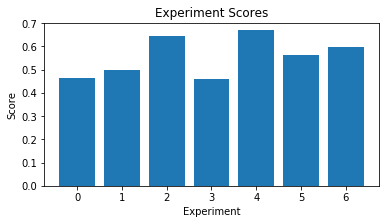

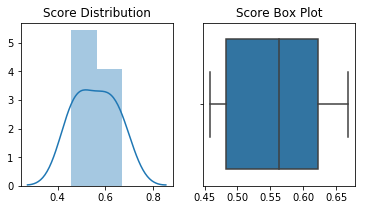

=== Statistics ===
Mean:  0.557
Median:  0.5625
Standard Dev:  0.0791
Range:  (0.4583, 0.6688)
	===	===	===	===	===

Running Elastic experiment...



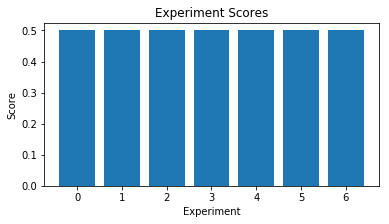

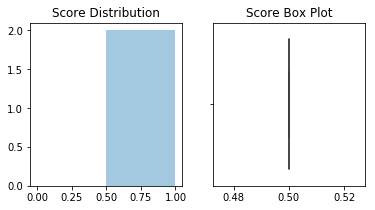

=== Statistics ===
Mean:  0.5
Median:  0.5
Standard Dev:  0.0
Range:  (0.5, 0.5)
	===	===	===	===	===

Running LogReg experiment...



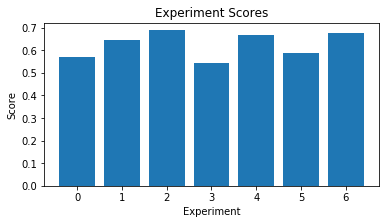

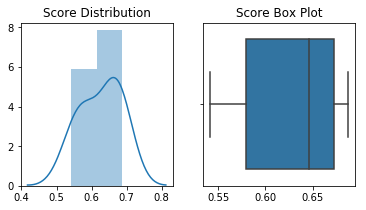

=== Statistics ===
Mean:  0.6255
Median:  0.6458
Standard Dev:  0.0535
Range:  (0.5417, 0.6875)
	===	===	===	===	===

Running GNB experiment...



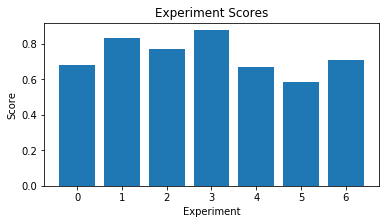

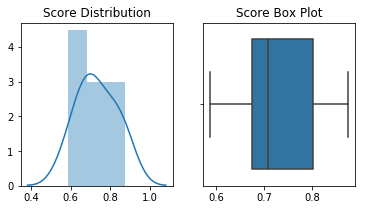

=== Statistics ===
Mean:  0.7318
Median:  0.7088
Standard Dev:  0.093
Range:  (0.5875, 0.875)
	===	===	===	===	===

Running RF experiment...



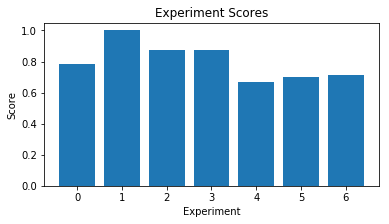

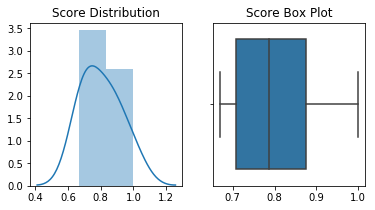

=== Statistics ===
Mean:  0.8027
Median:  0.7857
Standard Dev:  0.1108
Range:  (0.6688, 1.0)
	===	===	===	===	===

Running GBM experiment...



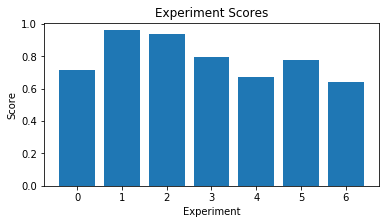

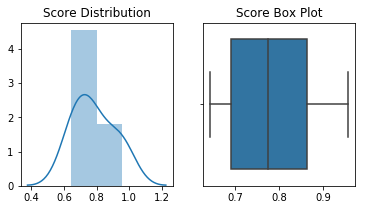

=== Statistics ===
Mean:  0.7841
Median:  0.775
Standard Dev:  0.1147
Range:  (0.6429, 0.9583)
	===	===	===	===	===

Running LinSVC experiment...



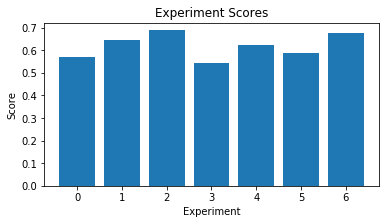

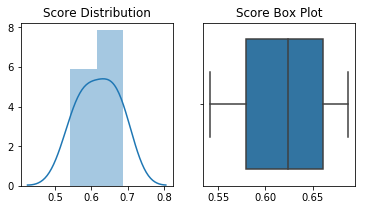

=== Statistics ===
Mean:  0.619
Median:  0.6234
Standard Dev:  0.0506
Range:  (0.5417, 0.6875)
	===	===	===	===	===

Running kNN experiment...



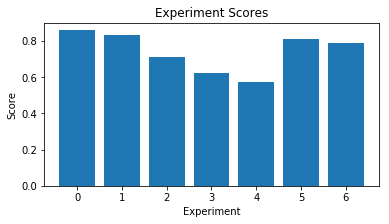

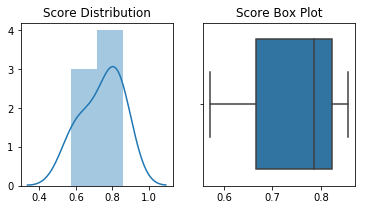

=== Statistics ===
Mean:  0.7419
Median:  0.7857
Standard Dev:  0.1017
Range:  (0.5714, 0.8571)
	===	===	===	===	===

Running Centroid experiment...



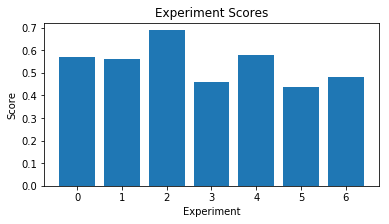

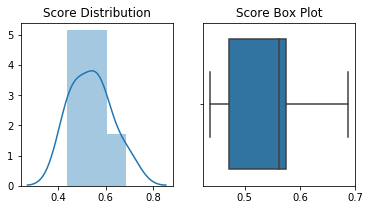

=== Statistics ===
Mean:  0.5398
Median:  0.5625
Standard Dev:  0.0802
Range:  (0.4375, 0.6875)
	===	===	===	===	===



In [17]:
sklearn_results = {}

for name, model in sklearn_models.items():
    print(f"Running {name} experiment...")
    print()
    scores = run_experiments(SEEDS, X, y, model[0], roc_auc_score, 0.3, verbose=False)
    sklearn_results[name] = scores
    print("\t===\t===\t===\t===\t===")
    print()

In [18]:
skl_results_df = pd.DataFrame(sklearn_results.values(), sklearn_results.keys())
skl_results_df['mean'] = skl_results_df.mean(axis=1)

top3_df = skl_results_df.sort_values(by='mean', axis=0, ascending=False).head(3)

In [19]:
top_3 = {k: sklearn_models[k] for k in top3_df.index}

In [20]:
top_3

{'RF': [sklearn.ensemble._forest.RandomForestClassifier],
 'GBM': [sklearn.ensemble._gb.GradientBoostingClassifier],
 'kNN': [sklearn.neighbors._classification.KNeighborsClassifier]}

In [21]:
BENCHMARK = top3_df.iloc[0]
BENCHMARK

0       0.785714
1       1.000000
2       0.875000
3       0.875000
4       0.668831
5       0.700000
6       0.714286
mean    0.802690
Name: RF, dtype: float64

In [22]:
#Now that we have the benchmark model and the top 3 we will use a randomized search
#over a hyperparameter space for each to find optimal configurations, then run
#the experiments again for these optimal configurations
rf_hp_space = {'n_estimators': np.arange(80, 120),
               'criterion': ['gini', 'entropy'],
               'max_depth': np.arange(2, 15),
               'min_samples_split': np.arange(2, 10),
               'min_samples_leaf': np.arange(1, 10),
               'max_features': ['sqrt', 'log2']
              }
gbm_hp_space = {'learning_rate': np.linspace(1e-4, 0.3, num=10),
                'n_estimators': np.arange(80, 120),
                'subsample': np.linspace(0.8, 1.0, num=10),
                'min_samples_split': np.arange(2, 10),
                'min_samples_leaf': np.arange(1, 10),
                'max_depth': np.arange(2, 15)
               }
knn_hp_space = {'n_neighbors': np.arange(2,10),
                'weights': ['uniform', 'distance'],
                'algorithm': ['ball_tree', 'kd_tree'],
                'leaf_size': np.arange(20,40)
               }

spaces = {'RF': rf_hp_space,
          'GBM': gbm_hp_space,
          'kNN': knn_hp_space
         }

In [23]:
#We investigate checking over a fixed proportion of the hyperparameter space
for space in spaces.values():
    dim = 1
    for val in space.values():
        dim *= len(val)
    print("Dimension of hyperparameter space: ", dim)
    print(f"5%: {dim*0.05}\t10%: {dim*0.1}\t20%: {dim*0.2}")

Dimension of hyperparameter space:  149760
5%: 7488.0	10%: 14976.0	20%: 29952.0
Dimension of hyperparameter space:  3744000
5%: 187200.0	10%: 374400.0	20%: 748800.0
Dimension of hyperparameter space:  640
5%: 32.0	10%: 64.0	20%: 128.0


In [24]:
#Due to the large values above, we will use 15 candidates per parameter
for model, space in spaces.items():
    candidates = 15 * len(space)
    spaces[model] = (candidates, space)
    print(model, candidates)

RF 90
GBM 90
kNN 60


In [25]:
#We will use a new subset of data
data_sub = data.sample(frac=0.2, replace = False)
X_sub = data_sub.drop(columns=["NoShow"])
y_sub = data_sub.NoShow

In [26]:
best_params = {}

for model_name, (candidates, space) in spaces.items():
    print(f"Optimizing {model_name}...")
    model = top_3[model_name][0]()
    clf = RandomizedSearchCV(model, space, candidates, 
                             random_state=SEED)
    search = clf.fit(X_sub, y_sub)
    print(f"Best score: {search.best_score_}")
    best_params[model_name] = search.best_params_

Optimizing RF...
Best score: 0.9177561637638544
Optimizing GBM...
Best score: 0.9170775842569554
Optimizing kNN...
Best score: 0.9016059714996608


In [27]:
best_params

{'RF': {'n_estimators': 83,
  'min_samples_split': 3,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'max_depth': 9,
  'criterion': 'entropy'},
 'GBM': {'subsample': 0.888888888888889,
  'n_estimators': 114,
  'min_samples_split': 2,
  'min_samples_leaf': 6,
  'max_depth': 2,
  'learning_rate': 0.23335555555555557},
 'kNN': {'weights': 'uniform',
  'n_neighbors': 9,
  'leaf_size': 21,
  'algorithm': 'ball_tree'}}

In [28]:
#The first line became necessary since the error "ValueError: Input contains NaN, 
#infinity or a value too large for dtype('float64')" was continually being raised,
#but checks for np.inf, np.nan, and -np.inf returned no rows with those values
data_copy = data.reset_index().astype(np.float64)
X = data_copy.drop(columns=["NoShow"])
y = data_copy.NoShow

Running RF experiment...

{'n_estimators': 83, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 9, 'criterion': 'entropy'}


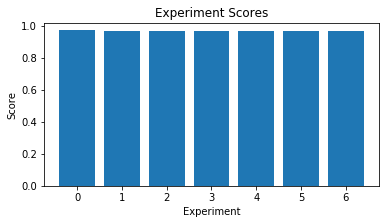

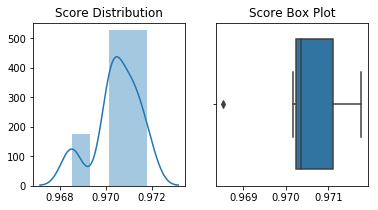

=== Statistics ===
Mean:  0.9705
Median:  0.9703
Standard Dev:  0.001
Range:  (0.9685, 0.9718)
	===	===	===	===	===

Running GBM experiment...

{'subsample': 0.888888888888889, 'n_estimators': 114, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_depth': 2, 'learning_rate': 0.23335555555555557}


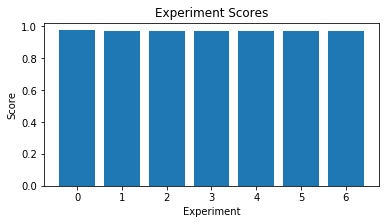

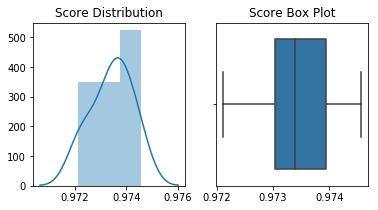

=== Statistics ===
Mean:  0.9734
Median:  0.9734
Standard Dev:  0.0008
Range:  (0.9721, 0.9746)
	===	===	===	===	===

Running kNN experiment...

{'weights': 'uniform', 'n_neighbors': 9, 'leaf_size': 21, 'algorithm': 'ball_tree'}


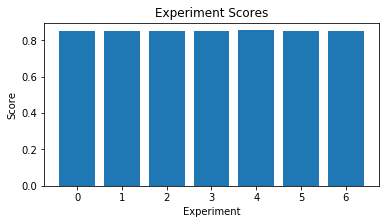

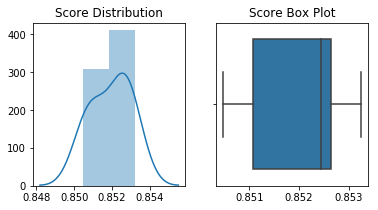

=== Statistics ===
Mean:  0.8519
Median:  0.8524
Standard Dev:  0.001
Range:  (0.8505, 0.8533)
	===	===	===	===	===



In [29]:
top3_results = {}

for name, params in best_params.items():
    model = top_3[name][0]
    print(f"Running {name} experiment...")
    print()
    print(params)
    scores = run_experiments(SEEDS, X, y, model, roc_auc_score, 0.3, params, verbose=False)
    top3_results[name] = scores
    print("\t===\t===\t===\t===\t===")
    print()

In [30]:
best_sklearn = {'GBM': best_params['GBM']}
best_sklearn

{'GBM': {'subsample': 0.888888888888889,
  'n_estimators': 114,
  'min_samples_split': 2,
  'min_samples_leaf': 6,
  'max_depth': 2,
  'learning_rate': 0.23335555555555557}}

In [31]:
class SNNTraining():
    """Object to house hyperparameter optimization and variables"""
    def __init__(self, train_loader, n_configs, embedding_size, num_cont_cols):
        """
        Instantiates a SNNTraining object to house best parameters while the
        search is being performed as well as other essential resources
            ARGS:
                train_loader(DataLoader):= dataloader containing the trainin data
                n_configs(int):= number of hyperparameter configurations to try
                embedding_size(list of tuples):= list of (# categories, embedding dim) 
                    tuples
                num_cont_cols(int):= number of columns of continuous variables in the
                    dataset
        """
        self.BEST_LR = np.random.uniform(0,0.015)
        self.BEST_MOMENTUM = np.random.normal(0.75, 0.07)
        self.BEST_NETWORK_SHAPE = np.random.choice(['rect','conic'])
        self.BEST_NUM_LAYERS = np.random.choice([2,3,4,5,8,16])
        self.BEST_FIRST_LAYER_SIZE = np.random.choice([128,256,512])
        self.BEST_LOSS = np.inf
        
        self.best_params_ = [self.BEST_LR, 
                             self.BEST_MOMENTUM, 
                             self.BEST_NETWORK_SHAPE, 
                             self.BEST_NUM_LAYERS, 
                             self.BEST_FIRST_LAYER_SIZE
                            ]
        
        self.train_loader = train_loader
        self.n_configs = n_configs
        self.embedding_size = embedding_size
        self.num_cont_cols = num_cont_cols
        
    def run_model(self, args):
        """
        Executes the evaluation of a provided hyperparameter configuration
            ARGS:
                args(tuple):= tuple containing the name of the parameter and
                    its value
            RETURN:
                average training loss for the configuration
        """
        param, val = args

        valid_shapes = ['rect', 'conic']
        valid_n_layers = [2, 4, 8, 16, 32]
        valid_first_sizes = [256, 512, 1024]

        if param == 'learning_rate':
            lr = val if val > 0 else -val
            momentum = self.BEST_MOMENTUM
            net_shape = self.BEST_NETWORK_SHAPE
            n_layers = self.BEST_NUM_LAYERS
            first_layer = self.BEST_FIRST_LAYER_SIZE
        elif param == 'momentum':
            lr = self.BEST_LR
            momentum = val if val < 1 else val-1.0
            net_shape = self.BEST_NETWORK_SHAPE
            n_layers = self.BEST_NUM_LAYERS
            first_layer = self.BEST_FIRST_LAYER_SIZE
        elif param == 'network_shape':
            lr = self.BEST_LR
            momentum = self.BEST_MOMENTUM
            net_shape = val
            while net_shape == self.BEST_NETWORK_SHAPE:
                net_shape = np.random.choice(valid_shapes)
            n_layers = self.BEST_NUM_LAYERS
            first_layer = self.BEST_FIRST_LAYER_SIZE
        elif param == 'num_layers':
            lr = self.BEST_LR
            momentum = self.BEST_MOMENTUM
            net_shape = self.BEST_NETWORK_SHAPE
            n_layers = val
            while n_layers == self.BEST_NUM_LAYERS:
                n_layers = np.random.choice(valid_n_layers)
            first_layer = self.BEST_FIRST_LAYER_SIZE
        elif param == 'first_layer_width':
            lr = self.BEST_LR
            momentum = self.BEST_MOMENTUM
            net_shape = self.BEST_NETWORK_SHAPE
            n_layers = self.BEST_NUM_LAYERS
            first_layer = val
            while first_layer == self.BEST_FIRST_LAYER_SIZE:
                first_layer = np.random.choice(valid_first_sizes)

        new_params = [lr, momentum, net_shape, n_layers, first_layer]

        model = NoShowModel(embed_sizes=self.embedding_size, 
                            num_cont=self.num_cont_cols,
                            first_layer_size=first_layer,
                            output_layer_size=1,
                            network_shape=net_shape,
                            num_layers=n_layers
                           )

        model.apply(init_weights)

        model_params = filter(lambda param: param.requires_grad, model.parameters())
        optimizer = optim.SGD(model_params, lr=lr, momentum=momentum, nesterov=True)
        criterion = nn.BCEWithLogitsLoss()

        model.train()
        train_loss = 0
        for x_embed, x_cont, y in self.train_loader:
            optimizer.zero_grad()
            output = model(x_embed, x_cont)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_embed.size(0)

        if train_loss < self.BEST_LOSS:
            self.BEST_LOSS = train_loss
            self.BEST_LR = lr
            self.BEST_MOMENTUM = momentum
            self.BEST_NETWORK_SHAPE = net_shape
            self.BEST_NUM_LAYERS = n_layers
            self.BEST_FIRST_LAYER_SIZE = first_layer

            print(f"New best LR: {self.BEST_LR}\np: {self.BEST_MOMENTUM}",
                    f"Shape: {self.BEST_NETWORK_SHAPE}\n#Layers: {self.BEST_NUM_LAYERS}",
                    f"First Width: {self.BEST_FIRST_LAYER_SIZE}")

        return train_loss / len(self.train_loader.dataset)
    
    def train(self, hyp_space):
        """
        Executes the search of the hyperparameter space
            ARGS:
                hype_space:= hyperopt selection from the
                    specified parameters and their domains
        """
        best = fmin(fn=lambda hypers: self.run_model(hypers),
                    space=hyp_space,
                    algo=tpe.suggest,
                    max_evals=self.n_configs
                   )

In [32]:
#Similarly we define the hyperparameter space and use 15 contenders since three of the parameters
#are discrete with a total dim of 30 (2*5*3) and only two are continuous
snn_space = hp.choice('hypers',
                      [('learning_rate', hp.normal('lr', 0, 0.015)),
                       ('momentum', hp.normal('mom', 0.75, 0.07)),
                       ('network_shape', hp.choice('shape', ['rect','conic'])),
                       ('num_layers', hp.choice('depth', [2,4,8,16,32])),
                       ('first_layer_width', hp.choice('width', [256,512,1024]))
                      ]
                     )

contenders = 15

In [33]:
embedding_col_names, embedding_sizes, cont_col_names = get_col_info(X_sub)
num_cont_cols = len(cont_col_names)

In [34]:
hyperopt_loader = utils.data.DataLoader(TabDataset(X_sub, y_sub, embedding_col_names),
                                        batch_size=32,
                                        shuffle=True
                                       )

In [35]:
snn = SNNTraining(hyperopt_loader, contenders, embedding_sizes, num_cont_cols)

In [36]:
snn.train(snn_space)

New best LR: 0.002741054636201188                     
p: 0.6558979244406817
Shape: conic                                          
#Layers: 8
First Width: 256                                      
New best LR: 0.01404568295602579                                                 
p: 0.6558979244406817
Shape: conic                                                                     
#Layers: 8
First Width: 256                                                                 
New best LR: 0.01404568295602579                                                 
p: 0.6558979244406817
Shape: conic                                                                     
#Layers: 8
First Width: 1024                                                                
New best LR: 0.01404568295602579                                                 
p: 0.6558979244406817
Shape: conic                                                                     
#Layers: 4
First Width: 1024                              

In [37]:
param_names = ['lr','momentum','network_shape','num_layers','first_layer_width']
snn_best_params = {k:v for k,v in zip(param_names, snn.best_params_)}
snn_best_params

{'lr': 0.002741054636201188,
 'momentum': 0.6558979244406817,
 'network_shape': 'conic',
 'num_layers': 16,
 'first_layer_width': 256}

In [38]:
def save_model(state_dict, filename):
    torch.save(state_dict, filename)
    print(f"Saved best model state_dict as {filename}")

In [39]:
def train(model, optimizer, criterion, epochs, 
          train_loader, test_loader, 
          save_name, stop_after=3,
          oclr_max=None):
    """
    Trains the SNN model and monitors the validation loss. It will save the model
    periodically as the validation loss decreases and will stop training early as
    defined. Broken into training and validation phases
        ARGS:
            model(NoShowModel):= custom defined torch based SNN model
            optimizer:= pytorch optimizer
            criterion:= pytorch loss function
            epochs(int):= number of times the model will train over the entire
                dataset
            train_loader(DataLoader):= dataloader containing the training data
            test_loader(DataLoader):= dataloader containing the testing data
            save_name(str):= filename to save the best model state
            stop_after(int):= number of epochs without improvement over best loss
                before training is stoped
            oclr_max(float):= max learning rate value for the OneCycle Learning Rate
                scheduler object
        RETURN:
            the model that obtained the lowest validation loss during training
    """
    best_valid_loss = np.inf
    best_model = None
    train_losses = []
    valid_losses = []
    
    stop_counter = 0
    
    if oclr_max:
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                                  max_lr=oclr_max,
                                                  steps_per_epoch=len(train_loader),
                                                  epochs=epochs
                                                 )
    
    for e in range(epochs):
        ############
        #Train loop#
        ############
        train_loss = 0
        model.train()
        for x_embed, x_cont, y in train_loader:
            optimizer.zero_grad()
            output = model(x_embed, x_cont)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_embed.size(0)
            
            if oclr_max:
                scheduler.step()

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        ############
        #Valid loop#
        ############
        valid_loss = 0
        model.eval()
        preds = []
        actuals = []
        for x_embed, x_cont, y in test_loader:
            output = model(x_embed, x_cont)
            loss = criterion(output,  y)
            valid_loss += loss.item() * x_embed.size(0)
            pred = torch.sigmoid(output).round()
            preds.append(pred)
            actuals.append(y)

        valid_loss = valid_loss / len(test_loader.dataset)
        valid_losses.append(valid_loss)
        
        preds_array = np.vstack([t.detach().numpy() for t in preds])
        actuals_array = np.vstack([t.detach().numpy() for t in actuals])
        auc = roc_auc_score(actuals_array, preds_array)

        print("===\t===\t===\t===\t===\t")
        print("Epoch {}:\n\tTraining Loss: {:.4f}\n\tValid Loss: {:.4f}".format(e+1, train_loss, valid_loss))
        print("ROC AUC: {:.4f}".format(auc))

        if valid_loss < best_valid_loss:
            save_model(model.state_dict(), f"{save_name}.pth")
            best_valid_loss = valid_loss
            best_model = model
            stop_counter = 0
        
        if valid_loss > best_valid_loss:
            stop_counter += 1
            print("Epochs without improvement over best: ",stop_counter)
            
        if stop_counter >= stop_after:
            return best_model
            
            
    return best_model

In [42]:
snn_scores = []
X = data.drop(columns=["NoShow"])
y = data.NoShow

torch.manual_seed(SEEDS[0])
#Prepare dataloaders
embedding_col_names, embedding_size, cont_col_names = get_col_info(X)
num_cont_cols = len(cont_col_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEEDS[0])
train_loader = utils.data.DataLoader(TabDataset(X_train, y_train, embedding_col_names),
                                     batch_size=32,
                                     shuffle=True
                                    )
test_loader = utils.data.DataLoader(TabDataset(X_test, y_test, embedding_col_names),
                                    batch_size=32,
                                    shuffle=True
                                   )

#Prepare model, optimizer, and criterion
model = NoShowModel(embed_sizes=embedding_size, 
                    num_cont=num_cont_cols,
                    first_layer_size=snn_best_params['first_layer_width'],
                    output_layer_size=1,
                    network_shape=snn_best_params['network_shape'],
                    num_layers=snn_best_params['num_layers']
                   )
model.apply(init_weights)

model_params = filter(lambda param: param.requires_grad, model.parameters())
optimizer = optim.SGD(model_params, lr=snn_best_params['lr'], 
                      momentum=snn_best_params['momentum'], nesterov=True)
criterion = nn.BCEWithLogitsLoss()

#Train model
best_model = train(model, 
                   optimizer, 
                   criterion, 
                   50,
                   train_loader, 
                   test_loader,
                   save_name=f"snn_model", 
                   stop_after=3, 
                   oclr_max=0.1)

===	===	===	===	===	
Epoch 1:
	Training Loss: 0.2843
	Valid Loss: 0.2059
ROC AUC: 0.7776
Saved best model state_dict as snn_model.pth
===	===	===	===	===	
Epoch 2:
	Training Loss: 0.2563
	Valid Loss: 0.1924
ROC AUC: 0.8383
Saved best model state_dict as snn_model.pth
===	===	===	===	===	
Epoch 3:
	Training Loss: 0.2518
	Valid Loss: 0.1969
ROC AUC: 0.8028
Epochs without improvement over best:  1
===	===	===	===	===	
Epoch 4:
	Training Loss: 0.2467
	Valid Loss: 0.2432
ROC AUC: 0.7166
Epochs without improvement over best:  2
===	===	===	===	===	
Epoch 5:
	Training Loss: 0.2490
	Valid Loss: 0.2260
ROC AUC: 0.9032
Epochs without improvement over best:  3


In [43]:
#Generate predictions for scoring
preds = []
actuals = []

best_model.eval()
for x_embed, x_cont, y in test_loader:
    output = best_model(x_embed, x_cont)
    pred = torch.sigmoid(output).round()
    preds.append(pred)
    actuals.append(y)

preds_array = np.vstack([t.detach().numpy() for t in preds])
actuals_array = np.vstack([t.detach().numpy() for t in actuals])

score = roc_auc_score(actuals_array, preds_array)

snn_scores.append(score)

In [44]:
snn_scores

[0.9032082091576302]